# Comparing Automated Feature Design Tools with the developed Methodology.

Tool tested: 
- TsFresh + EN
- AutoFeat

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import sklearn
from sklearn.model_selection import train_test_split

from autofeat import FeatureSelector, AutoFeatRegressor

import tsfresh
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)

# Custom functions
import src.basis as basis
from src.data_gen import generate_target_values

from src.helper import construct_data
from src.helper import optimise_pls_cv


In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'

# Shall plots be saved?
save_plots = False

# Path to save plots
# save_plot_path = './../Nullspace/Figures/' 
save_plot_path = './results/' 

# plt.style.use('./styles/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_response = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_response = False

In [3]:
# Import data
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

# Train test split according to Severson et al. 2019, Nature Energy
X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
var_function = lambda a: np.var(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_response: 
    y_lfp_train_syn = generate_target_values(X_lfp_train, mean_function, percentage_range_x_to_t=[0,1])
    # Contruct data object
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfp_train_syn)
    # Add noise to target values
    dml_lfp_syn = dml_lfp_syn.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_response: 
        np.savetxt(
            data_path + 'lfp_y_mean.csv', dml_lfp_syn.y, delimiter=",", 
            header='Sample Mean reposne for the LFP Data')
else:
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(
        X_lfp_train, x_lfp, np.loadtxt(data_path + 'lfp_y_mean.csv', skiprows=1, delimiter=','))

In [4]:
def addnoise(y, strength):
    yn = y + strength*y.std()*np.random.randn(len(y))
    return yn

In [5]:
X = X_lfp_train
y1 = generate_target_values(X, mean_function, percentage_range_x_to_t=[0,1])
y1n = addnoise(y1, 0.1)

y2 = generate_target_values(X, var_function, percentage_range_x_to_t=[0,1])
y2n = addnoise(y2, 0.1)

y3 = generate_target_values(X, var_function, percentage_range_x_to_t=[0.3,6])
y3n = addnoise(y3, 0.1)

In [14]:
# Results of Auto Tools
steps=1
afreg = AutoFeatRegressor(verbose=0, feateng_steps=steps)
df = afreg.fit_transform(X, np.log(y_lfp_train_true))

In [15]:
r2 = afreg.score(X, np.log(y_lfp_train_true))
print("## Final Train R^2: %.4f" % r2)
r2 = afreg.score(X_lfp_test, np.log(y_lfp_test_true))
print("## Final Test 1 R^2: %.4f" % r2)
r2 = afreg.score(X_lfp_test2, np.log(y_lfp_test2_true))
print("## Final Test 2 R^2: %.4f" % r2)

## Final Train R^2: 0.5707
## Final Test 1 R^2: 0.4679
## Final Test 2 R^2: -45.6938


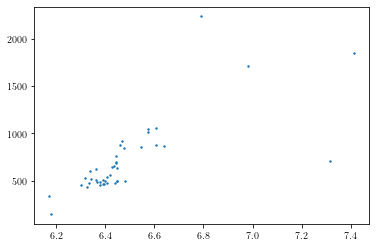

In [17]:
# Autsch! Thats quite horrible. High-dimensions suck apparently big time!
plt.figure()
plt.scatter(afreg.predict(X_lfp_test), y_lfp_test_true, s=2)

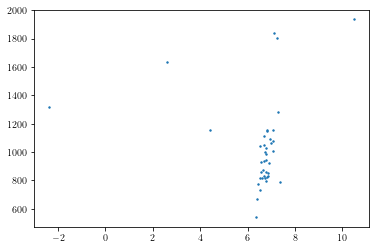

In [18]:
plt.figure()
plt.scatter(afreg.predict(X_lfp_test2), y_lfp_test2_true, s=2)
#cplt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2, len(afreg.new_feat_cols_)))

In [ ]:
dml_lfp_syn.y

array([-0.00410672, -0.00747333, -0.01113769, -0.01654914, -0.00839705,
       -0.0110246 , -0.01334155, -0.02010342, -0.03059094, -0.01386938,
       -0.01774514, -0.01674176, -0.01780922, -0.02076346, -0.01604281,
       -0.02091984, -0.02674492, -0.01261606, -0.02058562, -0.02931673,
       -0.07143547, -0.02462706, -0.03224838, -0.03946971, -0.02771648,
       -0.03712465, -0.02429798, -0.03142333, -0.02619873, -0.02739028,
       -0.02660757, -0.02291284, -0.01761595, -0.02182271, -0.01969316,
       -0.02337286, -0.02333222, -0.02541829, -0.02571441, -0.02839477,
       -0.02087656])

In [19]:
# TsFresh
from tsfresh import extract_features, extract_relevant_features, select_features

In [21]:
X = pd.DataFrame(X)

In [22]:
X_tsfresh = extract_features(X)

ValueError: A value for column_id needs to be supplied

In [25]:
X.index

RangeIndex(start=0, stop=41, step=1)